# SDC P5: Vehicle Detection and Tracking

## HOG Features

Get HOG features. And experiment to find a good combination of parameters

Explore data

In [1]:
from VDT_v1 import *
import random

# Visualizations will be shown in the notebook.
%matplotlib inline

cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/non-vehicles/*/*.png')
# images.extend(glob.glob('../data/non-vehicles_smallset/*/*.jpeg'))

data_info = data_look(cars, notcars)
print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ', data_info["image_shape"], ' and data type:',
      data_info["data_type"])

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


Randomly select and display an example image of both cars and notcars

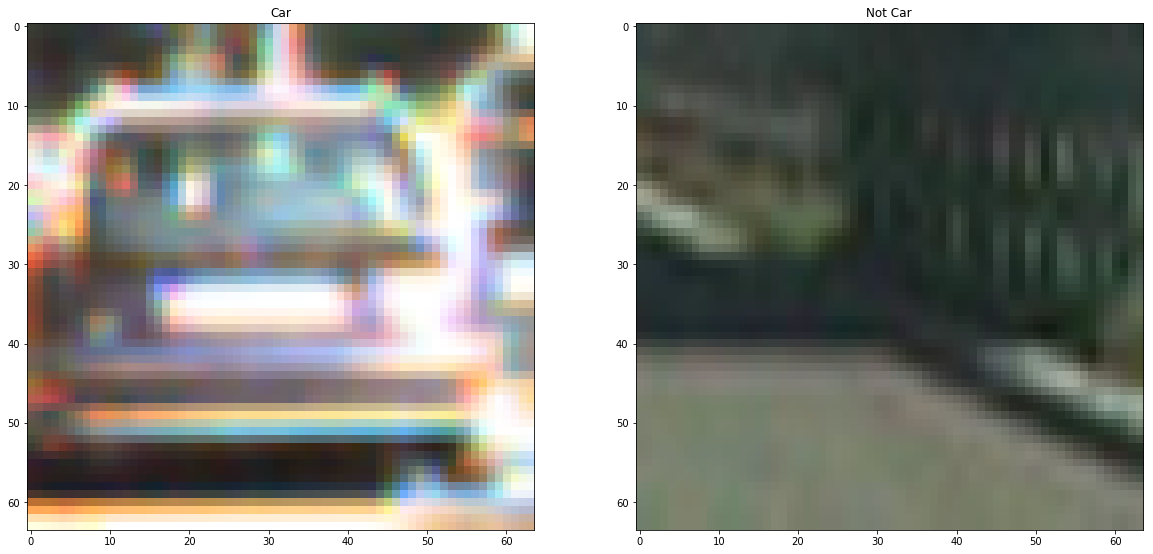

In [2]:

car = mpimg.imread(cars[random.randint(0, data_info["n_cars"]-1)])
notcar = mpimg.imread(notcars[random.randint(0, data_info["n_notcars"]-1)])

plt.figure(figsize=(20,40))
plt.subplot(1,2,1)
plt.imshow(car)
plt.title('Car')
plt.subplot(1,2,2)
plt.imshow(notcar)
plt.title('Not Car')
plt.savefig('./output_images/car_notcar.jpg', bbox_inches="tight")

Display HOG features and color features as well

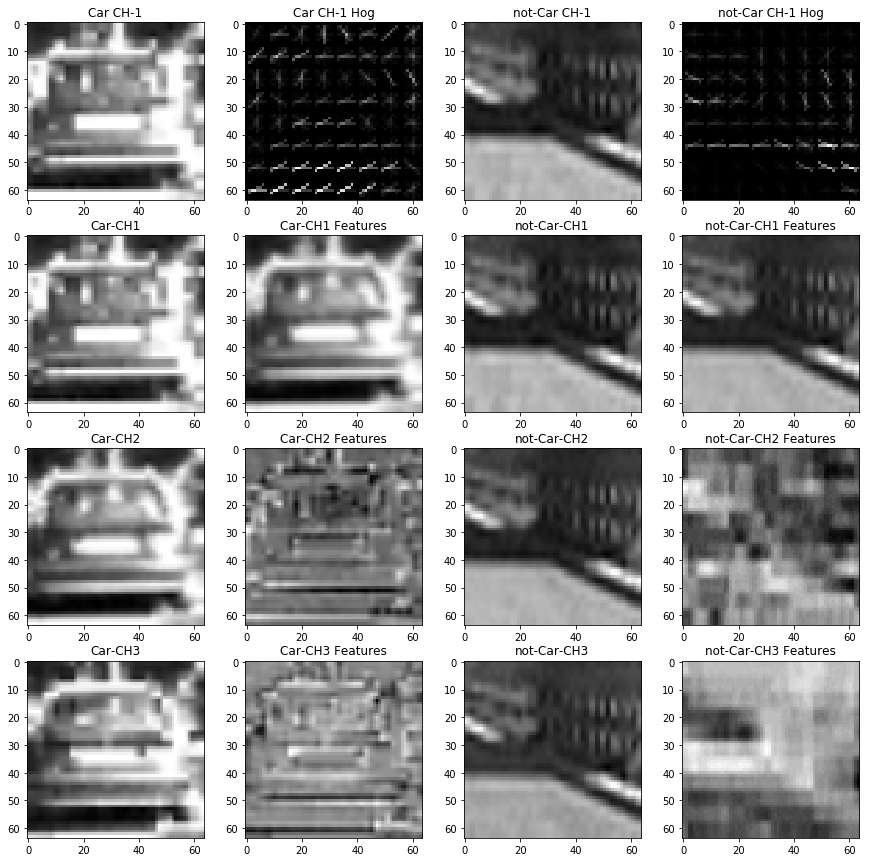

In [3]:
imgs = []
imgs.append(car[:,:,0])

color_space = 'YCrCb'
car_feature_image = convert_color(car, color_space)
notcar_feature_image = convert_color(notcar, color_space)

orient = 8
pix_per_cell = 8
cell_per_block = 2

f, car_hog_1 = get_hog_features(car_feature_image[:,:,0], orient, pix_per_cell, cell_per_block,
                     vis=True, feature_vec=True)

f, notcar_hog_1 = get_hog_features(notcar_feature_image[:,:,0], orient, pix_per_cell, cell_per_block,
                     vis=True, feature_vec=True)

plt.figure(figsize=(15,15))

plt.subplot(4,4,1)
plt.imshow(car[:,:,0], cmap='gray')
plt.title('Car CH-1')

plt.subplot(4,4,2)
plt.imshow(car_hog_1, cmap='gray')
plt.title('Car CH-1 Hog')

plt.subplot(4,4,3)
plt.imshow(notcar[:,:,0], cmap='gray')
plt.title('not-Car CH-1')

plt.subplot(4,4,4)
plt.imshow(notcar_hog_1, cmap='gray')
plt.title('not-Car CH-1 Hog')

for i in range(3):
    plt.subplot(4,4,4+i*4+1)
    plt.imshow(car[:,:,i], cmap='gray')
    plt.title('Car-CH'+str(i+1))

    plt.subplot(4,4,4+i*4+2)
    plt.imshow(car_feature_image[:,:,i], cmap='gray')
    plt.title('Car-CH'+str(i+1)+' Features')

    plt.subplot(4,4,4+i*4+3)
    plt.imshow(notcar[:,:,i], cmap='gray')
    plt.title('not-Car-CH'+str(i+1))

    plt.subplot(4,4,4+i*4+4)
    plt.imshow(notcar_feature_image[:,:,i], cmap='gray')
    plt.title('not-Car-CH'+str(i+1)+' Features')
    
plt.savefig('./output_images/features.jpg', bbox_inches="tight")

In [2]:
def find_cars_box(img, color_space,
              xstart, ystart, xstop, ystop,
              scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins):
    """Find cars in an image
    :return list of boxes
    """

    box_list = []

    img_tosearch = img[ystart:ystop, xstart:xstop, :]
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)  # RGB2YCrCb
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1] / scale), np.int(imshape[0] / scale)))

    ch1 = ctrans_tosearch[:, :, 0]
    ch2 = ctrans_tosearch[:, :, 1]
    ch3 = ctrans_tosearch[:, :, 2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1
    nfeat_per_block = orient * cell_per_block ** 2

    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb * cells_per_step
            xpos = xb * cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos + nblocks_per_window, xpos:xpos + nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos * pix_per_cell
            ytop = ypos * pix_per_cell

#             # Extract the image patch
#             subimg = cv2.resize(ctrans_tosearch[ytop:ytop + window, xleft:xleft + window], (64, 64))

#             # Get color features
#             spatial_features = bin_spatial(subimg, size=spatial_size)
#             hist_features = color_hist(subimg, nbins=hist_bins)

#             # Scale features and make a prediction
#             test_features = X_scaler.transform(
#                 np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))
#             # test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))
#             test_prediction = svc.predict(test_features)


            xbox_left = np.int(xleft * scale)
            ytop_draw = np.int(ytop * scale)
            win_draw = np.int(window * scale)

            box_list.append([(xbox_left + xstart, ytop_draw + ystart),
                             (xbox_left + xstart + win_draw, ytop_draw + win_draw + ystart)])
    return box_list  # draw_img

Scale 3

[(0, 400), (192, 592)]


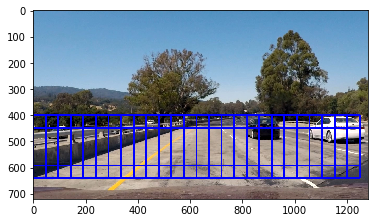

In [22]:
img = mpimg.imread('./test_images/test1.jpg')

box_list = []

xstart = 0
ystart = 400
xstop = img.shape[1]
ystop = 656
scale = 3

orient = 8
pix_per_cell = 8
cell_per_block = 4
spatial_size = 32
hist_bins = 32

box_list2 = find_cars_box(img, 'RGB',
              xstart, ystart, xstop, ystop,
              scale, 0, 0,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
box_list.extend(box_list2)
print(box_list[0])

out = draw_boxes(img, box_list)
plt.imshow(out)
plt.savefig('./output_images/sb_3.jpg', bbox_inches="tight")

Scale 2

[(0, 400), (128, 528)]


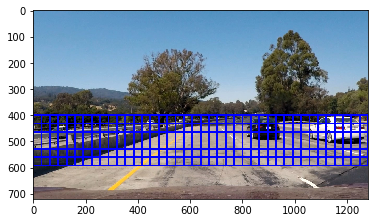

In [24]:
img = mpimg.imread('./test_images/test1.jpg')

box_list = []

orient = 8
pix_per_cell = 8
cell_per_block = 4
spatial_size = 32
hist_bins = 32

xstart = 0
ystart = 400
xstop = img.shape[1]
ystop = 600
scale = 2

box_list2 = find_cars_box(img, 'RGB',
              xstart, ystart, xstop, ystop,
              scale, 0, 0,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
box_list.extend(box_list2)
print(box_list[0])

out = draw_boxes(img, box_list)
plt.imshow(out)
plt.savefig('./output_images/sb_2.jpg', bbox_inches="tight")

Scale 1

[(400, 400), (464, 464)]


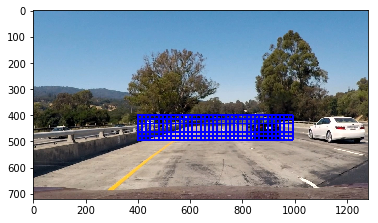

In [25]:
img = mpimg.imread('./test_images/test1.jpg')

box_list = []

orient = 8
pix_per_cell = 8
cell_per_block = 4
spatial_size = 32
hist_bins = 32

xstart = 400
ystart = 400
xstop = 1000
ystop = 500
scale = 1

box_list2 = find_cars_box(img, 'RGB',
              xstart, ystart, xstop, ystop,
              scale, 0, 0,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
box_list.extend(box_list2)
print(box_list[0])

out = draw_boxes(img, box_list)
plt.imshow(out)
plt.savefig('./output_images/sb_1.jpg', bbox_inches="tight")

[(700, 400), (716, 416)]


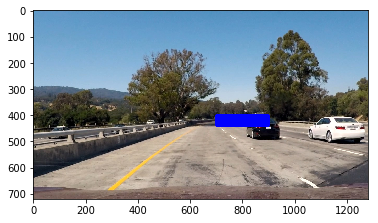

In [27]:
img = mpimg.imread('./test_images/test1.jpg')

box_list = []

orient = 8
pix_per_cell = 8
cell_per_block = 4
spatial_size = 32
hist_bins = 32

xstart = 700
ystart = 400
xstop = 900
ystop = 440
scale = 0.25

box_list2 = find_cars_box(img, 'RGB',
              xstart, ystart, xstop, ystop,
              scale, 0, 0,
              orient, pix_per_cell, cell_per_block,
              spatial_size, hist_bins)
box_list.extend(box_list2)
print(box_list[0])

out = draw_boxes(img, box_list)
plt.imshow(out)
plt.savefig('./output_images/sb_0_25.jpg', bbox_inches="tight")

In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
import matplotlib.pyplot as plt
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block,
                     vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient,
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True,
                                  visualise=vis, feature_vector=feature_vec,
                                  block_norm='L2-Hys')
        return features, hog_image
    # Otherwise call with one output
    else:
        features = hog(img, orientations=orient,
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),
                       transform_sqrt=True,
                       visualise=vis, feature_vector=feature_vec,
                       block_norm='L2-Hys')
        return features


# Define a function to compute binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel()
    # Return the feature vector
    return features


# Define a function to compute color histogram features
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:, :, 0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:, :, 1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:, :, 2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                     hist_bins=32, orient=9,
                     pix_per_cell=8, cell_per_block=2, hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else:
            feature_image = np.copy(image)

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:, :, channel],
                                                         orient, pix_per_cell, cell_per_block,
                                                         vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)
            else:
                hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                                pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [2]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # 1) Define an empty list to receive features
    img_features = []
    # 2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    # 3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # 4) Append features to list
        img_features.append(spatial_features)
    # 5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # 6) Append features to list
        img_features.append(hist_features)
    # 7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:, :, channel],
                                                     orient, pix_per_cell, cell_per_block,
                                                     vis=False, feature_vec=True))
        else:
            hog_features = get_hog_features(feature_image[:, :, hog_channel], orient,
                                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # 8) Append features to list
        img_features.append(hog_features)

    # 9) Return concatenated array of features
    return np.concatenate(img_features)

In [3]:

def extract_features(imgs, ext='jpeg', color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # If using PNG images, scale it to 0-255 from 0-1
        if ext == 'png':
            image = image*255
            image = image.astype(np.uint8)
        feature = single_img_features(image, color_space='RGB', spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        features.append(feature)
    return features

Explore dataset.

In [4]:
# Define a function to return some characteristics of the dataset
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    tmp_im = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = tmp_im.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = tmp_im.dtype

    # Return data_dict
    return data_dict

In [5]:
import glob

# Divide up into cars and notcars
# images = glob.glob('*.jpeg')
cars = glob.glob('./data/vehicles/*/*.png')
notcars = glob.glob('./data/vehicles/*/*.png')
# images.extend(glob.glob('../data/non-vehicles_smallset/*/*.jpeg'))

data_info = data_look(cars, notcars)
print('Your function returned a count of',
      data_info["n_cars"], ' cars and',
      data_info["n_notcars"], ' non-cars')
print('of size: ', data_info["image_shape"], ' and data type:',
      data_info["data_type"])


Your function returned a count of 8792  cars and 8792  non-cars
of size:  (64, 64, 3)  and data type: float32


In [12]:
orient=9
pix_per_cell = 8
cell_per_block =2
color_space = 'RGB'
hist_bins = 32
spatial_size = (32, 32)
hog_channel = 'ALL'

t = time.time()
car_features = extract_features(cars, ext='png', color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)

notcar_features = extract_features(notcars, ext='png', color_space=color_space, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract features...')



127.9 Seconds to extract features...


In [13]:
print(len(car_features))
print(len(car_features[0]))
print(len(car_features[1]))

print(len(notcar_features))
print(len(notcar_features[0]))
print(len(notcar_features[1]))

8792
8460
8460
8792
8460
8460


In [15]:
from sklearn.model_selection import train_test_split
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:', orient, 'orientations', pix_per_cell,
      'pixels per cell and', cell_per_block, 'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [ ]:
# Use a linear SVC
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

In [ ]:
if 1:
    dist_pickle = {}
    dist_pickle["svc"] = svc
    dist_pickle["scaler"] = X_scaler
    dist_pickle["orient"] = orient
    dist_pickle["pix_per_cell"] = pix_per_cell
    dist_pickle["cell_per_block"] = cell_per_block
    dist_pickle["spatial_size"] = spatial_size
    dist_pickle["hist_bins"] = hist_bins
    pickle.dump(dist_pickle, open("../data/svc_pickle.p", "wb"))

In [ ]:
# Check the prediction time for a single sample
t = time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these', n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2 - t, 5), 'Seconds to predict', n_predict, 'labels with SVC')

In [1]:
from VehicleDetector import *

vd = VehicleDetector('./result/svc_pickle_complete_v2_2018_02_04_05_06_04.p',
                    numbuf=3, thresh=6)


In [2]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'output_images/test_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("./project_video.mp4").subclip(20,45)
clip1 = VideoFileClip("./test_video.mp4")#.subclip(18,48)

#clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,3)
#white_output = 'output_images/challenge_output_1.mp4'
#clip1 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,2)
#white_output = 'output_images/harder_challenge_output_1.mp4'

white_clip = clip1.fl_image(vd.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/test_output.mp4
[MoviePy] Writing video output_images/test_output.mp4


 97%|█████████▋| 38/39 [00:20<00:00,  1.89it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/test_output.mp4 

CPU times: user 22.6 s, sys: 712 ms, total: 23.4 s
Wall time: 21.2 s


In [3]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [4]:
print_prof_data()

Function find_cars called 117 times. 
Execution time max: 0.343, average: 0.165
Function detect called 39 times. 
Execution time max: 0.562, average: 0.523


In [5]:

vd = VehicleDetector('./result/svc_pickle_complete_v2_2018_02_04_05_06_04.p',
                    numbuf=3, thresh=6)

white_output = 'output_images/project_output.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("./project_video.mp4").subclip(20,45)
clip1 = VideoFileClip("./project_video.mp4")#.subclip(18,48)

#clip1 = VideoFileClip("./challenge_video.mp4").subclip(0,3)
#white_output = 'output_images/challenge_output_1.mp4'
#clip1 = VideoFileClip("./harder_challenge_video.mp4").subclip(0,2)
#white_output = 'output_images/harder_challenge_output_1.mp4'

white_clip = clip1.fl_image(vd.detect) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video output_images/project_output.mp4
[MoviePy] Writing video output_images/project_output.mp4


100%|█████████▉| 1260/1261 [10:54<00:00,  1.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_output.mp4 

CPU times: user 12min 34s, sys: 5.29 s, total: 12min 39s
Wall time: 10min 55s


In [6]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [7]:
print_prof_data()

Function find_cars called 3900 times. 
Execution time max: 0.388, average: 0.167
Function detect called 1300 times. 
Execution time max: 0.573, average: 0.515
